In [6]:
import cellrank as cr
import scvelo as scv
import scanpy as sc
import numpy as np
import loompy
import anndata
import pandas as pd

In [7]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

# Load data

## load seurat data

In [14]:
obj = sc.read_h5ad("/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/cellrank/takeda_39metastaticSamples_mt10_SCTmerge_CD4T_noTreg020622.h5ad")

In [15]:
obj = obj[obj.obs['SCT_snn_res.0.4'] != 7]
obj.obs["Ident"] = ''
obj.obs.loc[obj.obs['SCT_snn_res.0.4'] == 0, "Ident"] = 'c0(Tn)'
obj.obs.loc[obj.obs['SCT_snn_res.0.4'] == 6, "Ident"] = 'c0(Tn)'
obj.obs.loc[obj.obs['SCT_snn_res.0.4'] == 2, "Ident"] = 'c2(CD69+ T)'
obj.obs.loc[obj.obs['SCT_snn_res.0.4'] == 3, "Ident"] = 'c3(Tm)'
obj.obs.loc[obj.obs['SCT_snn_res.0.4'] == 4, "Ident"] = 'c3(Tm)'
obj.obs.loc[obj.obs['SCT_snn_res.0.4'] == 5, "Ident"] = 'c4(Tex)'


Trying to set attribute `.obs` of view, copying.


In [16]:
obj.obs.Ident = obj.obs.Ident.astype('category')

In [17]:
meta = obj.obs

In [18]:
def get_seuratbarcode(meta):
    return meta.sample_ID_long + '_'+meta.cell_barcode.str.split("-",expand=True)[0]

meta['sample_barcode'] = get_seuratbarcode(meta)

## load velocyto loom files

In [19]:
label_table = pd.read_csv('/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/velocyto_loom_label.csv')

In [16]:
# import glob

# files = glob.glob("/net/bmc-lab5/data/kellis/group/Fu_Doris/velocyto/D*/*.loom")+glob.glob("/net/bmc-lab5/data/kellis/group/Fu_Doris/velocyto/hsc*/*.loom")
# len(files)

39

In [18]:
# loompy.combine(label_table.loom, '/net/bmc-lab5/data/kellis/group/Fu_Doris/velocyto/takeda_39metastaticSamples_combined012822.loom', key="Accession")

In [20]:
loom_merged = anndata.read_loom("/net/bmc-lab5/data/kellis/group/Fu_Doris/velocyto/takeda_39metastaticSamples_combined012822.loom")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
loom_merged

AnnData object with n_obs × n_vars = 344121 × 36601
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [22]:
label_dict = dict(zip(label_table.label, label_table.sample_ID_long))

In [23]:
def get_sampleID(loom_index, label_dict):
    label = loom_index.split(':')[0]
    label = label.split('_')[-1]
    return label_dict[label]

def get_loombarcode(loom_index, label_dict):
    label, bar = loom_index.split(':')
    label = label.split('_')[-1]
    bar = bar.split('x')[0]
    return label_dict[label]+'_'+bar

In [24]:
loomsampleID = [get_sampleID(c,label_dict) for c in loom_merged.obs.index.values]
loombarcode = [get_loombarcode(c,label_dict) for c in loom_merged.obs.index.values]

In [25]:
loom_merged.obs['sample_ID_long'] = loomsampleID
loom_merged.obs['sample_barcode'] = loombarcode
loom_merged.obs['CellID'] = loom_merged.obs.index.values


In [26]:
loom_merged.obs.index = loom_merged.obs['sample_barcode']

## filter cells

In [27]:
adata = loom_merged[np.isin(loom_merged.obs.sample_barcode, meta.sample_barcode)]

In [28]:
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [29]:
obj

AnnData object with n_obs × n_vars = 14564 × 18536
    obs: 'sample_ID', 'is_multiplet', 'cell_barcode', 'total_counts', 'percent_ribo', 'percent_heme', 'n_genes', 'compartment', 'general_cell_type', 'sample_ID_long', 'patient', 'uid', 'age', 'sex', 'subtype', 'treatment_group', 'prior_therapy', 'state', 'response', 'tissue', 'day', 'pfs', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'SCT_snn_res.0.6', 'seurat_clusters', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'monocle3_pseudotime', 'Ident', 'sample_barcode'
    var: 'features'
    obsm: 'X_DC', 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [30]:
adata

AnnData object with n_obs × n_vars = 9971 × 36601
    obs: 'sample_ID_long', 'sample_barcode', 'CellID'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## missing cells

In [71]:
loom_merged.obs['sample_ID_long'].value_counts()

D19-11989     31351
D21-194010    26711
D19-1691      20488
D19-11997     17583
D19-9123      17355
D19-288       16941
D19-11990     15191
D19-284       14739
D19-11994     11613
D21-194011    11319
D21-194004    11034
D21-194002     9337
D19-11966      9223
D19-289        8444
D18-11809      7990
D19-12000      7608
D21-194009     7462
D19-6313       7416
D19-11965      7389
D21-194006     7134
D19-11964      6947
D19-9129       6395
D19-11995      6321
D18-11808      6037
D19-11969      5675
D19-6307       5576
D19-11999      5097
D19-1690       4674
D19-290        4417
D19-9118       4263
D19-11962      4022
D19-1692       3494
D21-194008     3468
D19-11963      3364
D19-11971      2477
D19-11960      2228
D18-11807      1677
D21-194005     1161
D19-9127        500
Name: sample_ID_long, dtype: int64

In [78]:
notinadata = meta[~np.isin(meta.sample_barcode,loom_merged.obs.sample_barcode)]

## Add in UMAP and cluster label

... storing 'sample_ID' as categorical
... storing 'is_multiplet' as categorical
... storing 'cell_barcode' as categorical
... storing 'compartment' as categorical
... storing 'general_cell_type' as categorical
... storing 'sample_ID_long' as categorical
... storing 'uid' as categorical
... storing 'sex' as categorical
... storing 'subtype' as categorical
... storing 'treatment_group' as categorical
... storing 'prior_therapy' as categorical
... storing 'state' as categorical
... storing 'response' as categorical
... storing 'tissue' as categorical
... storing 'Phase' as categorical


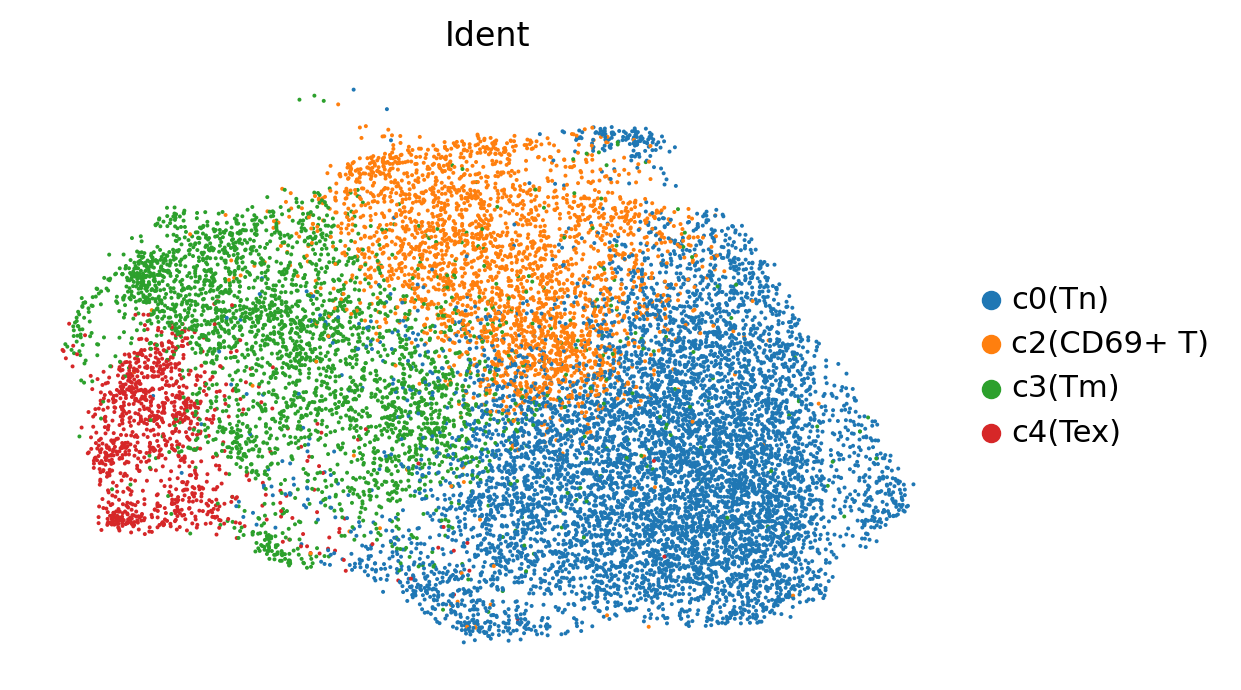

In [31]:
sc.pl.umap(obj,color="Ident", frameon = False)

In [33]:
obj

AnnData object with n_obs × n_vars = 14564 × 18536
    obs: 'sample_ID', 'is_multiplet', 'cell_barcode', 'total_counts', 'percent_ribo', 'percent_heme', 'n_genes', 'compartment', 'general_cell_type', 'sample_ID_long', 'patient', 'uid', 'age', 'sex', 'subtype', 'treatment_group', 'prior_therapy', 'state', 'response', 'tissue', 'day', 'pfs', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'SCT_snn_res.0.6', 'seurat_clusters', 'SCT_snn_res.0.8', 'SCT_snn_res.1', 'monocle3_pseudotime', 'Ident', 'sample_barcode'
    var: 'features'
    uns: 'Ident_colors'
    obsm: 'X_DC', 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [35]:
umap = pd.DataFrame(obj.obsm['X_umap'])

In [36]:
umap.index = obj.obs.sample_barcode

In [37]:
adata_index = pd.DataFrame(adata.obs.index)
umap_ordered = adata_index.merge(umap, on = "sample_barcode")

In [38]:
umap_ordered = umap_ordered.iloc[:,1:]
adata.obsm['X_umap'] = umap_ordered.values

In [39]:
cluster_ordered = adata_index.merge(meta[['sample_barcode','Ident']], on = "sample_barcode")

In [40]:
cluster_ordered= cluster_ordered.iloc[:,1:]
adata.obs['Ident'] = cluster_ordered.values

In [41]:
adata

AnnData object with n_obs × n_vars = 9971 × 36601
    obs: 'sample_ID_long', 'sample_barcode', 'CellID', 'Ident'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

# Estimate RNA velocity

In [42]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

## preprocess data

In [43]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 28934 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## run scVelo

In [44]:
scv.tl.recover_dynamics(adata, n_jobs=16)

recovering dynamics (using 16/96 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [45]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/96 cores)
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [3]:
# adata = sc.read_h5ad("/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/cellrank/takeda_39metastaticSamples_mt10_SCTmerge_CD4T_scVelocity020322.h5ad")
# adata.write("/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/cellrank/takeda_39metastaticSamples_mt10_SCTmerge_CD4T_scVelocity020322.h5ad")

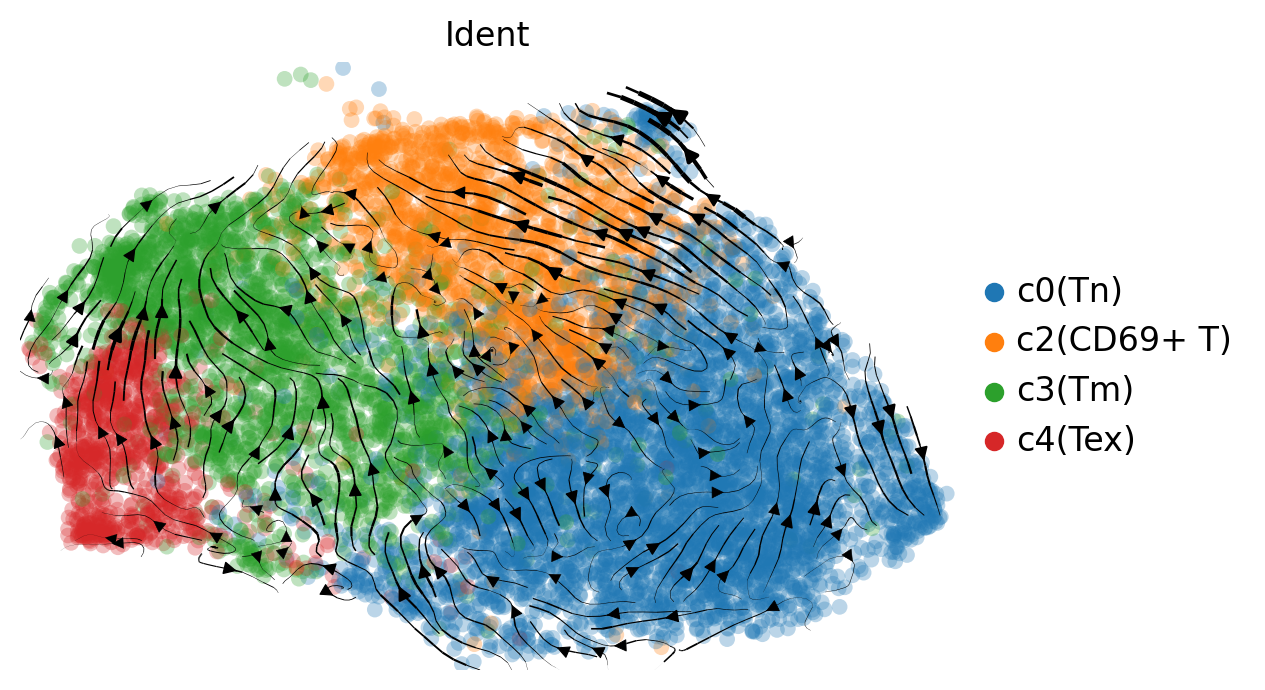

In [50]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12,legend_loc="right", 
     color_map="gnuplot2", color = 'Ident'
)

In [66]:
# adata
adata.obs.index.name = "cellID"

In [3]:
# adata = sc.read_h5ad("/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/cellrank/takeda_39metastaticSamples_mt10_SCTmerge_CD8T_scVelocity013122.h5ad")


## identify terminal states


In [51]:
cr.tl.terminal_states(adata, cluster_key = 'Ident', weight_connectivities=0.2)

Accessing `adata.obsp['T_fwd']`


/tmp/ipykernel_162791/4123788300.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata, cluster_key = 'Ident', weight_connectivities=0.2)


Computing transition matrix based on logits using `'deterministic'` mode


/net/bmc-lab5/data/kellis/users/ruiwenfu/conda_related/envs/cellrank/lib/python3.8/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


100%|███████████████████████████████████████████████████████████████████████████████| 9971/9971 [00:04<00:00, 2020.25cell/s]


Setting `softmax_scale=3.7592`


100%|███████████████████████████████████████████████████████████████████████████████| 9971/9971 [00:04<00:00, 2450.72cell/s]


    Finish (0:00:10)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:01)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


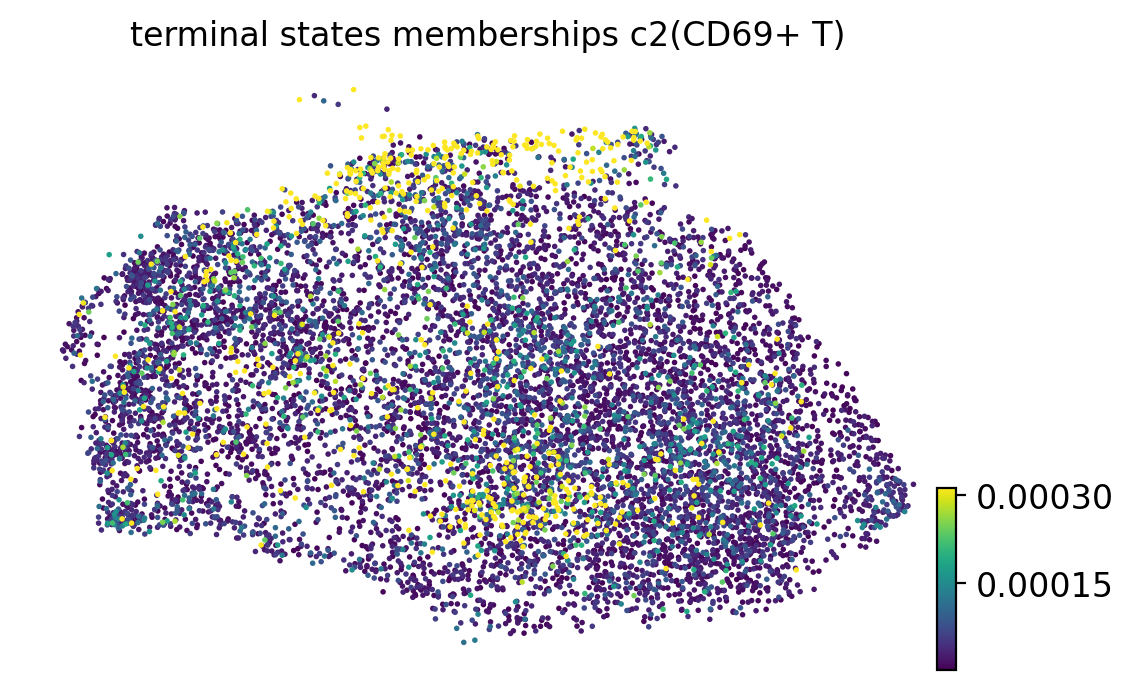

In [52]:
cr.pl.terminal_states(adata)


## identify initial states

In [54]:
cr.tl.initial_states(adata, weight_connectivities=0.2, cluster_key = 'Ident', 
                     fit_kwargs={"method": "brandts"})


Accessing `adata.obsp['T_bwd']`
Computing transition matrix based on logits using `'deterministic'` mode


/tmp/ipykernel_162791/1941148670.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, weight_connectivities=0.2, cluster_key = 'Ident',
/net/bmc-lab5/data/kellis/users/ruiwenfu/conda_related/envs/cellrank/lib/python3.8/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


Estimating `softmax_scale` using `'deterministic'` mode


100%|███████████████████████████████████████████████████████████████████████████████| 9971/9971 [00:04<00:00, 2102.18cell/s]


Setting `softmax_scale=3.7592`


100%|███████████████████████████████████████████████████████████████████████████████| 9971/9971 [00:04<00:00, 2219.96cell/s]


    Finish (0:00:10)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_bwd']`
       `.eigendecomposition`
    Finish (0:00:01)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


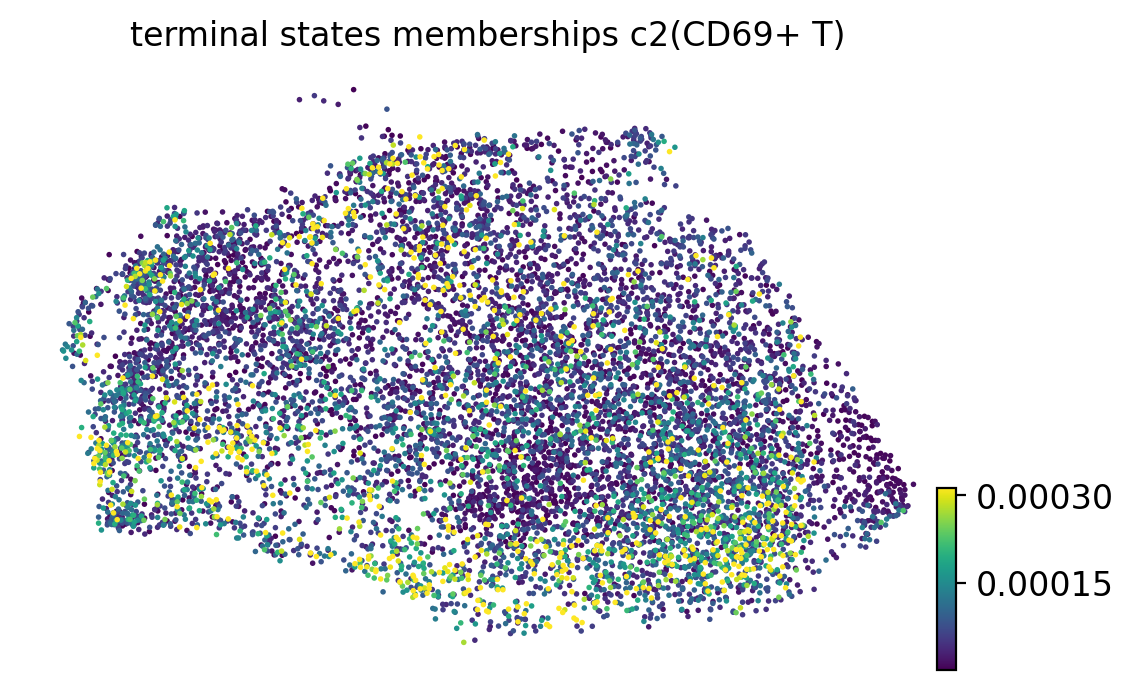

In [55]:
cr.pl.initial_states(adata)

In [56]:
cr.tl.lineages(adata, use_petsc=False)

Computing absorption probabilities


/tmp/ipykernel_162791/1033603950.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata, use_petsc=False)
100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


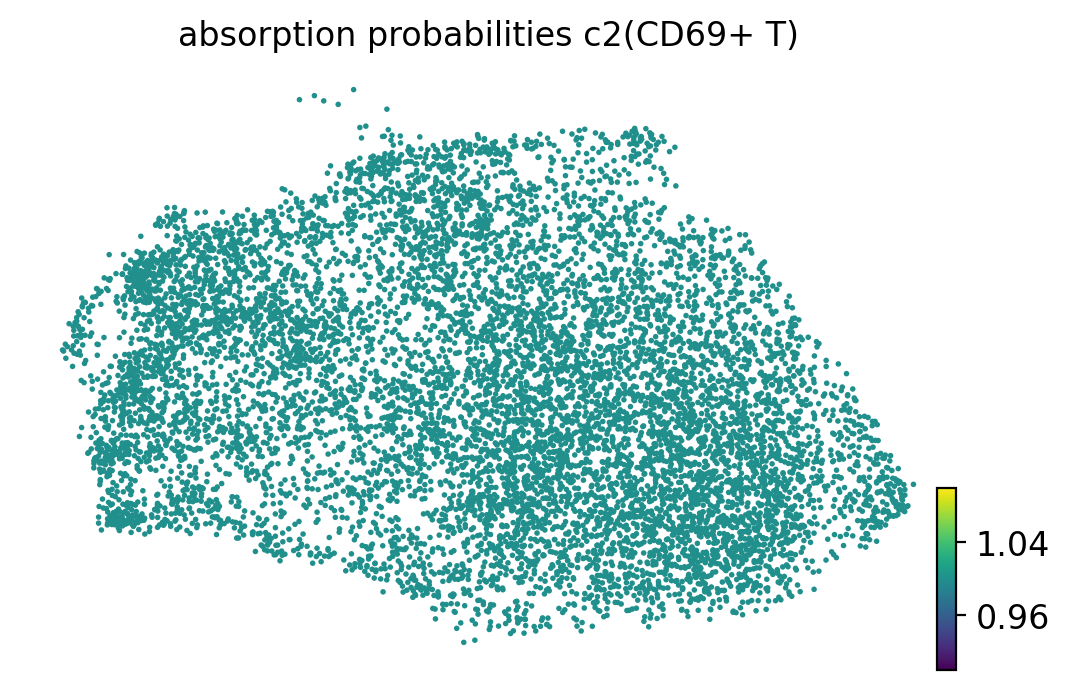

In [57]:
cr.pl.lineages(adata)


# Directed PAGA

In [ ]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

In [ ]:
scv.tl.paga(
    adata,
    groups="Ident",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

In [ ]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="Ident",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
)